## Libraries

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier

#Load dataset

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
dataset = pd.read_csv(io.BytesIO(uploaded['titanic.csv']), header=0)

Saving titanic.csv to titanic.csv


# Exploring Dataset

In [ ]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Variables Description

| Variable|Description|
|:---:|----------:|
|survival|	Survival	0 = No, 1 = Yes
|pclass	|Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
|sex	|Sex	
|Age	|Age in years	
|sibsp|	# of siblings / spouses aboard the Titanic	
|parch|	# of parents / children aboard the Titanic	
|ticket|	Ticket number	
|fare	|Passenger fare	
|cabin|	Cabin number	
|embarked|	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

## Preprocessing Data

Determine those columns with missing values

In [ ]:
dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
#Apply an imputation method
imp = SimpleImputer(strategy="most_frequent")
array_transformation=imp.fit_transform(dataset.loc[:,['Age','Cabin','Embarked']])
dataset["Age"]=array_transformation[:,0]
dataset["Cabin"]=array_transformation[:,1]
dataset["Embarked"]=array_transformation[:,2]
#Additionally transform Age column to integer column
dataset["Age"]=dataset["Age"].astype(int)
dataset.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,B96 B98,S


Transform label values

In [ ]:
#Encode label values
to_be_encoded=dataset.loc[:,['Sex','Cabin','Embarked']]

le_s = preprocessing.LabelEncoder()
encoded_sex=le_s.fit_transform(to_be_encoded['Sex'])
dataset['Sex']=encoded_sex

le_c = preprocessing.LabelEncoder()
encoded_cabin=le_c.fit_transform(to_be_encoded['Cabin'])
dataset['Cabin']=encoded_cabin

le_e = preprocessing.LabelEncoder()
encoded_emb=le_c.fit_transform(to_be_encoded['Embarked'])
dataset['Embarked']=encoded_emb




In [ ]:
dataset[['Sex','Cabin','Embarked']].head()
len(dataset['Cabin'].unique())


147

In [ ]:
dataset.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Sex           -0.543351
Age           -0.052883
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Cabin          0.175690
Embarked      -0.167675
Name: Survived, dtype: float64

### **Does make sense a correlation between non-numerical values?**

Discussion:

In [ ]:
features_to_be_encoded=['Survived','Pclass','Sex','Embarked']
enc=OneHotEncoder()
encoded_data =enc.fit_transform(dataset[features_to_be_encoded])
encoded_data=pd.DataFrame.sparse.from_spmatrix(encoded_data)
encoded_data.columns=enc.get_feature_names(features_to_be_encoded)
encoded_data.head()

,Survived_0,Survived_1,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


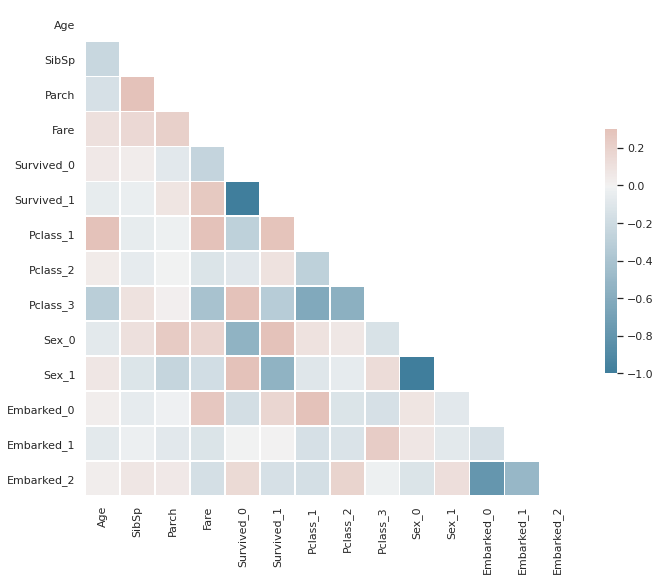

In [ ]:
numerical_features=['Age','SibSp','Parch','Fare']
final_data=pd.concat([dataset[numerical_features],encoded_data], axis=1)

correlation_matrix=final_data.corr(method="pearson") #Use only predictor variables
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# Feature Selection

## Sort correlations

In [ ]:
my_filter=correlation_matrix['Survived_0']>=0
print(correlation_matrix.loc[my_filter, 'Survived_0'].sort_values(ascending=False))
my_filter=correlation_matrix['Survived_0']<0
print(correlation_matrix.loc[my_filter, 'Survived_0'].sort_values(ascending=True))

my_filter=correlation_matrix['Survived_1']>=0
print(correlation_matrix.loc[my_filter, 'Survived_1'].sort_values(ascending=False))
my_filter=correlation_matrix['Survived_1']<0
print(correlation_matrix.loc[my_filter, 'Survived_1'].sort_values(ascending=True))

Survived_0    1.000000
Sex_1         0.543351
Pclass_3      0.322308
Embarked_2    0.149683
Age           0.052883
SibSp         0.035322
Name: Survived_0, dtype: float64
Survived_1   -1.000000
Sex_0        -0.543351
Pclass_1     -0.285904
Fare         -0.257307
Embarked_0   -0.168240
Pclass_2     -0.093349
Parch        -0.081629
Embarked_1   -0.003650
Name: Survived_0, dtype: float64
Survived_1    1.000000
Sex_0         0.543351
Pclass_1      0.285904
Fare          0.257307
Embarked_0    0.168240
Pclass_2      0.093349
Parch         0.081629
Embarked_1    0.003650
Name: Survived_1, dtype: float64
Survived_0   -1.000000
Sex_1        -0.543351
Pclass_3     -0.322308
Embarked_2   -0.149683
Age          -0.052883
SibSp        -0.035322
Name: Survived_1, dtype: float64


## Choose the most correlated variables as predictors

In [ ]:
columns=['Sex_1','Pclass_3', 'Embarked_2','Age','SibSp','Sex_0','Pclass_1','Fare','Embarked_0']
X = final_data.loc[:,columns] #predictors
y = dataset.loc[:,'Survived'] #outcome


## Define Training and Test Datasets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1)
print("Training %d instances"%(x_train.shape[0]))
print("Test %d instances"%(x_test.shape[0]))

Training 668 instances
Test 223 instances


#Random Forest

## Example of training and prediction

In [ ]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(x_train, y_train)
pred=rf.predict(x_test)
acc=metrics.accuracy_score(y_test, pred)
print(acc)


0.7802690582959642


## Finding a set of suitable parameters

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
###############################################################################
# Use an instance of GridSearchCV to find  the best set of parameters  
###############################################################################
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}
cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(x_train, y_train)
print_results(cv)

#Bagging Approach


## Training and Prediction



In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
#Step 1
#This combine estimation either by voting or by averaging
clf = BaggingClassifier(base_estimator=SVC(),
                         n_estimators=10, random_state=0)
print(clf)
#Step 2
clf.fit(x_train, y_train)
pred=clf.predict(x_test)
acc=metrics.accuracy_score(y_test, pred)
print(acc)


BaggingClassifier(base_estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                     class_weight=None, coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma='scale', kernel='rbf', max_iter=-1,
                                     probability=False, random_state=None,
                                     shrinking=True, tol=0.001, verbose=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=0, verbose=0, warm_start=False)
0.6322869955156951


## Finding a set of suitable parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
clf = BaggingClassifier()
parameters = {
    'n_estimators': [5, 20, 100],
     'bootstrap':[True, False ]
}
cv = GridSearchCV(clf, parameters, cv=5)
cv.fit(x_train, y_train)
print_results(cv)

BEST PARAMS: {'bootstrap': True, 'n_estimators': 100}

0.81 (+/-0.058) for {'bootstrap': True, 'n_estimators': 5}
0.81 (+/-0.034) for {'bootstrap': True, 'n_estimators': 20}
0.816 (+/-0.071) for {'bootstrap': True, 'n_estimators': 100}
0.775 (+/-0.009) for {'bootstrap': False, 'n_estimators': 5}
0.769 (+/-0.017) for {'bootstrap': False, 'n_estimators': 20}
0.768 (+/-0.015) for {'bootstrap': False, 'n_estimators': 100}


#Boosting Approach Based on Gradient
1.   This uses as homegeneous weak learners (regression trees)
2.   It is based on the negative gradient of the binomial or multinomial deviance loss function.



## Training and Prediction

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
print(clf)
clf.fit(x_train, y_train)
clf.score(x_test,y_test)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


0.7847533632286996

## Finding a set of suitable parameters

In [ ]:
clf = GradientBoostingClassifier()
parameters = {
    'n_estimators': [5, 20, 100],
     'learning_rate':[0.1, 0.01,0.001],
     'criterion':['friedman_mse', 'mse', 'mae']
}
cv = GridSearchCV(clf, parameters, cv=5)
cv.fit(x_train, y_train)
print_results(cv)

# Others Boosting Approaches

## AdaBoostClassifier: Training and Prediction


1. Adaptative boosting  
2. By default, it uses DecisionTreeClassifier initialized with max_depth=1 as base estimator
3.   It begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases



In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1)
print(clf)
clf.fit(x_train, y_train)
clf.score(x_test,y_test)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)


0.757847533632287

In [ ]:
clf = AdaBoostClassifier()
parameters = {
    'n_estimators': [5, 20,50,100],
     'learning_rate':[0.001, 0.1, 1.0, 1.5,3.0]
     
}
cv = GridSearchCV(clf, parameters, cv=5)
cv.fit(x_train, y_train)
print_results(cv)

BEST PARAMS: {'learning_rate': 1.0, 'n_estimators': 50}

0.787 (+/-0.098) for {'learning_rate': 0.001, 'n_estimators': 5}
0.787 (+/-0.098) for {'learning_rate': 0.001, 'n_estimators': 20}
0.787 (+/-0.098) for {'learning_rate': 0.001, 'n_estimators': 50}
0.787 (+/-0.098) for {'learning_rate': 0.001, 'n_estimators': 100}
0.787 (+/-0.098) for {'learning_rate': 0.1, 'n_estimators': 5}
0.787 (+/-0.098) for {'learning_rate': 0.1, 'n_estimators': 20}
0.79 (+/-0.084) for {'learning_rate': 0.1, 'n_estimators': 50}
0.796 (+/-0.09) for {'learning_rate': 0.1, 'n_estimators': 100}
0.789 (+/-0.099) for {'learning_rate': 1.0, 'n_estimators': 5}
0.795 (+/-0.086) for {'learning_rate': 1.0, 'n_estimators': 20}
0.801 (+/-0.06) for {'learning_rate': 1.0, 'n_estimators': 50}
0.798 (+/-0.05) for {'learning_rate': 1.0, 'n_estimators': 100}
0.799 (+/-0.085) for {'learning_rate': 1.5, 'n_estimators': 5}
0.786 (+/-0.087) for {'learning_rate': 1.5, 'n_estimators': 20}
0.793 (+/-0.053) for {'learning_rate': 1.5, 

# Advance Ensambling Methods

XGBoost: 

Extreme Gradient Boosting, which uses gradient boosted trees.

See: [API Documentation](https://xgboost.readthedocs.io/en/latest/install.html)


In [ ]:
D#!pip install xgboost 
import xgboost as xgb
param_dist = {'objective':'binary:logistic', 'n_estimators':20}
clf = xgb.XGBClassifier(**param_dist)
#x_train["Sex_1"] = x_train["Sex_1"].values.to_dense().astype(np.float64)
#x_train["Pclass_3"] = x_train["Pclass_3"].values.to_dense().astype(np.float64)
#x_train["Embarked_2"] = x_train["Embarked_2"].values.to_dense().astype(np.float64)
#x_train["Sex_0"] = x_train["Sex_0"].values.to_dense().astype(np.float64)
#x_train["Embarked_0"] = x_train["Embarked_0"].values.to_dense().astype(np.float64)
#x_train["Pclass_1"] = x_train["Pclass_1"].values.to_dense().astype(np.float64)

#x_test["Sex_1"] = x_test["Sex_1"].values.to_dense().astype(np.float64)
#x_test["Pclass_3"] = x_test["Pclass_3"].values.to_dense().astype(np.float64)
#x_test["Embarked_2"] = x_test["Embarked_2"].values.to_dense().astype(np.float64)
#x_test["Sex_0"] = x_test["Sex_0"].values.to_dense().astype(np.float64)
#x_test["Embarked_0"] = x_test["Embarked_0"].values.to_dense().astype(np.float64)
#x_test["Pclass_1"] = x_test["Pclass_1"].values.to_dense().astype(np.float64)
#x_train.info()
print(clf)
clf.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=False)
clf.predict_proba(x_test)
y_pred=clf.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)





XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


0.7847533632286996

## 3. Stacking Techniques